In [28]:
import os
os.chdir("modulo/")

[autoreload of optimization failed: Traceback (most recent call last):
  File "C:\Users\fetet\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\fetet\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\fetet\Anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\fetet\Anaconda3\lib\importlib\__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'optimization'
]


FileNotFoundError: [WinError 2] O sistema não pode encontrar o arquivo especificado: 'modulo/'

# Hackaton Itaú Asset
- Equipe W.O.



Primeiramente, importaremos as bibliotecas usadas no notebook

In [29]:
import numpy as np 
import pandas as pd 
import metrics
import optimization as opt
import matplotlib.pyplot as plt
import seaborn as sns
from xbbg import blp
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
os.chdir("..")

- Consultando a API da Bloomberg para obtermos os dados necessários.
- Como alguns ETFs não possuem a quantidade ideal para estimarmos a matriz de covariância(10 meses), usamos os índices os quais os ETFs replicam.

In [31]:
dados = blp.bdh(['BOVV11 BZ Equity', 'SPXI11 BZ Equity', "IMAB11 BZ Equity","IRFM11 BZ Equity" ], 
                'PX_LAST', '2016-05-8', '2021-04-30')
dados_antigos = blp.bdh(["IBOV Index", "SPXT Index", "BZRFIMAB Index", "BZRFIRFM Index"],
                       'PX_LAST', '2016-05-8', '2021-04-30')

dados.columns = ["BOVV11","SPXI11", "IMAB11", "IRFM11"]
dados_antigos.columns = ["BOVV11","SPXI11", "IMAB11", "IRFM11"]

retornos = dados.pct_change()
retornos_antigos = dados_antigos.pct_change()

retornos[retornos.isnull()] = retornos_antigos
retornos = retornos.dropna()

In [32]:
retornos.head()

,BOVV11,SPXI11,IMAB11,IRFM11
2016-05-10,0.040808,-0.003671,0.008295,0.004789
2016-05-11,-0.005773,-0.013646,0.004704,0.002928
2016-05-12,0.009036,0.009131,0.006527,0.002116
2016-05-13,-0.026990,0.006169,0.001644,-0.000518
2016-05-16,-0.000027,0.002589,0.001013,-0.000967


### Estimando a Matriz de Covariância
- Para estimarmos a Matriz de Covariância usamos a técnica apresentada no artigo "Honey, I Shrunk the Sample Covariance Matrix".
- Nele, os autores propõem uma melhor forma de fugir de erros de amostragem, fazendo uma combinação entre a matriz da amostra mais uma matriz de correlação constante.

<center>
    $$\hat{\Sigma} = \delta \hat{S} + (1-\delta) \hat{F}$$
<center/>
Onde $S$ é a matriz da amostra, e $F$ a matriz de correlação constante

In [33]:
M = metrics.CovarianceEstimator(retornos)
Omega, _ = M.honey_shrinkage()
pd.DataFrame(Omega, index=retornos.columns, columns=retornos.columns)

,BOVV11,SPXI11,IMAB11,IRFM11
BOVV11,0.000292,0.000054,0.000042,0.000015
SPXI11,0.000054,0.000183,0.000003,-0.000001
IMAB11,0.000042,0.000003,0.000035,0.000007
IRFM11,0.000015,-0.000001,0.000007,0.000010


In [34]:
np.sqrt(Omega.diagonal())

array([0.01710194, 0.01354283, 0.00594977, 0.00322331])

## Construindo a Fronteira Eficiente
- Estimando a média histórica dos preços

In [35]:
n = retornos.shape[1]
er = dados.mean().values.reshape((n,1))

- Obtenção da fronteira eficiente

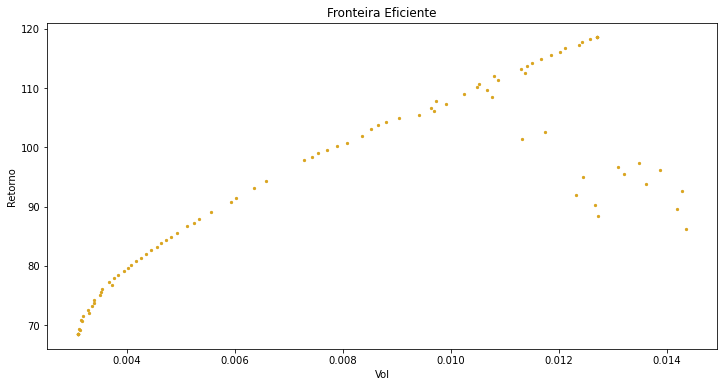

In [36]:
markowitz = opt.Markowitz(er, Omega, sim=100000)
markowitz.draw_ef(n_points = 100)
plt.title("Fronteira Eficiente")
plt.show()

<AxesSubplot:xlabel='Vol'>

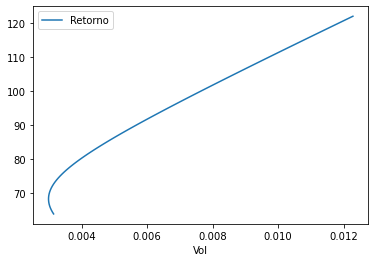

In [37]:
retornos = np.linspace(np.min(er), np.max(er), 100)
carteiras = [markowitz.minimize_ipm(i) for i in retornos]
        
r = [float(metrics.portfolio_return(carteira.reshape(4,1), er)) for carteira in carteiras]
vol = [float(metrics.portfolio_vol(carteira.reshape(4,1), Omega)) for carteira in carteiras]
        
df = pd.DataFrame({"Retorno": r, "Vol":vol})
df.plot(x="Vol", y= "Retorno")

In [27]:
carteiras

[array([[-0.04421239],
        [ 0.00303315],
        [ 0.07304496],
        [ 0.96813428]]),
 array([[-0.04416928],
        [ 0.0112117 ],
        [ 0.08199361],
        [ 0.95096397]]),
 array([[-0.04412618],
        [ 0.01939024],
        [ 0.09094227],
        [ 0.93379367]]),
 array([[-0.04408307],
        [ 0.02756879],
        [ 0.09989092],
        [ 0.91662337]]),
 array([[-0.04403997],
        [ 0.03574733],
        [ 0.10883957],
        [ 0.89945307]]),
 array([[-0.04399686],
        [ 0.04392588],
        [ 0.11778822],
        [ 0.88228276]]),
 array([[-0.04395376],
        [ 0.05210442],
        [ 0.12673688],
        [ 0.86511246]]),
 array([[-0.04391065],
        [ 0.06028297],
        [ 0.13568553],
        [ 0.84794216]]),
 array([[-0.04386755],
        [ 0.06846151],
        [ 0.14463418],
        [ 0.83077186]]),
 array([[-0.04382444],
        [ 0.07664005],
        [ 0.15358283],
        [ 0.81360155]]),
 array([[-0.04378134],
        [ 0.0848186 ],
        [ 0.16